# L2RPN Neurips 2020 Track1 SMALL environment

In [6]:
import pathlib
from pprint import pprint

#### Set the paths for data and cofiguration file

In [7]:
LIPS_PATH = pathlib.Path().resolve().parent
DATA_PATH = LIPS_PATH / "reference_data" / "l2rpn_neurips_2020_track1_small"
LOG_PATH = LIPS_PATH / "lips_logs_neurips.log"
CONFIG_PATH = LIPS_PATH / "lips" / "config" / "conf_nips_track1.ini"

Create the path for this environment

In [8]:
if not DATA_PATH.exists():
    DATA_PATH.mkdir(mode=511, parents=False)

## Benchmark1

In [4]:
from lips.benchmark import PowerGridBenchmark
benchmark1 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark1",
                                load_data_set=False,
                                config_path=CONFIG_PATH, # opt for default config path (benchmark/config.ini)
                                log_path=LOG_PATH)

2022-05-12 11:28:27.622819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 11:28:27.622870: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
benchmark1.generate(nb_sample_train=int(1e5),
                    nb_sample_val=int(1e4),
                    nb_sample_test=int(1e4),
                    nb_sample_test_ood_topo=int(1e4),
                   )

test_ood_topo: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:51<00:00, 89.94it/s]


# Visualization 

## Benchmark1

In [12]:
from lips.benchmark import PowerGridBenchmark
benchmark1 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark1",
                                load_data_set=True, # set to True to load the generated dataset
                                config_path=CONFIG_PATH, # opt for default config path (benchmark/config.ini)
                                log_path=LOG_PATH)

### Training scenarios

In [13]:
from lips.plot.power_grid import PlotData
obs_plotter = PlotData(dataset=benchmark1.train_dataset, env_name=benchmark1.env_name)

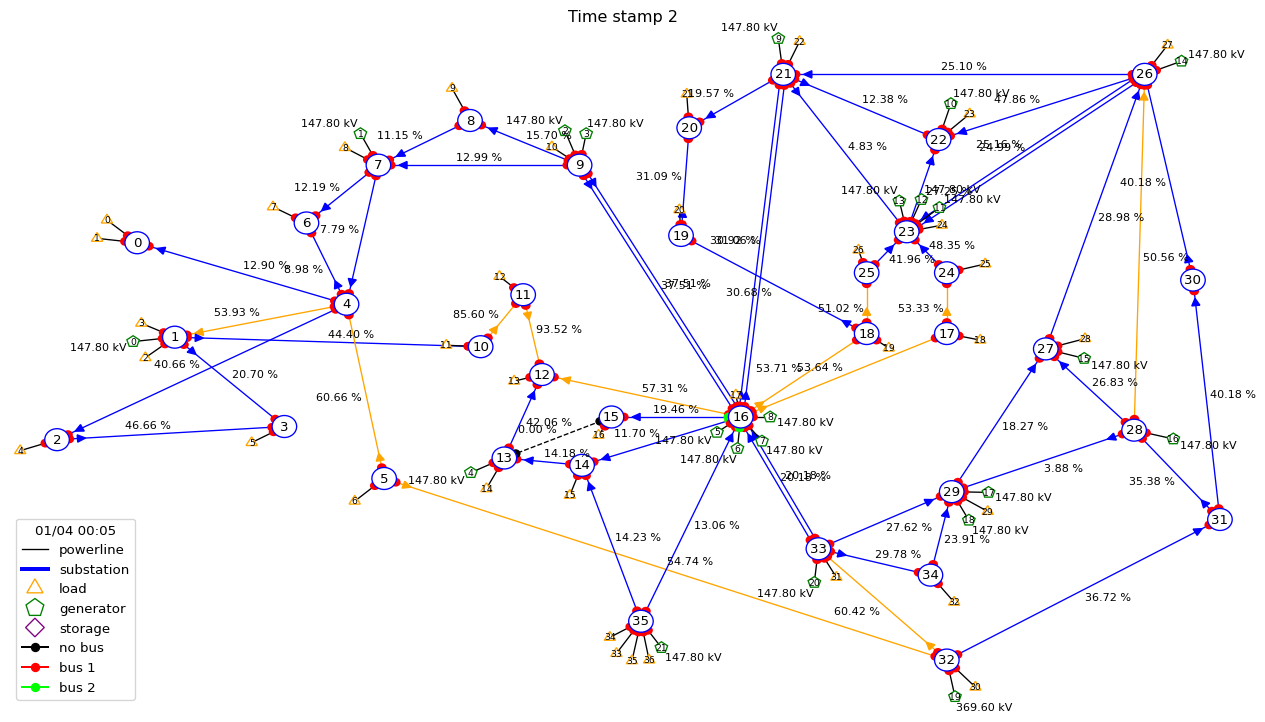

In [15]:
obs_plotter.visualize_next()

### Test scenarios
There is always one power line disconnected at random. 

In [16]:
from lips.plot.power_grid import PlotData
obs_plotter = PlotData(dataset=benchmark1._test_dataset, env_name=benchmark1.env_name)

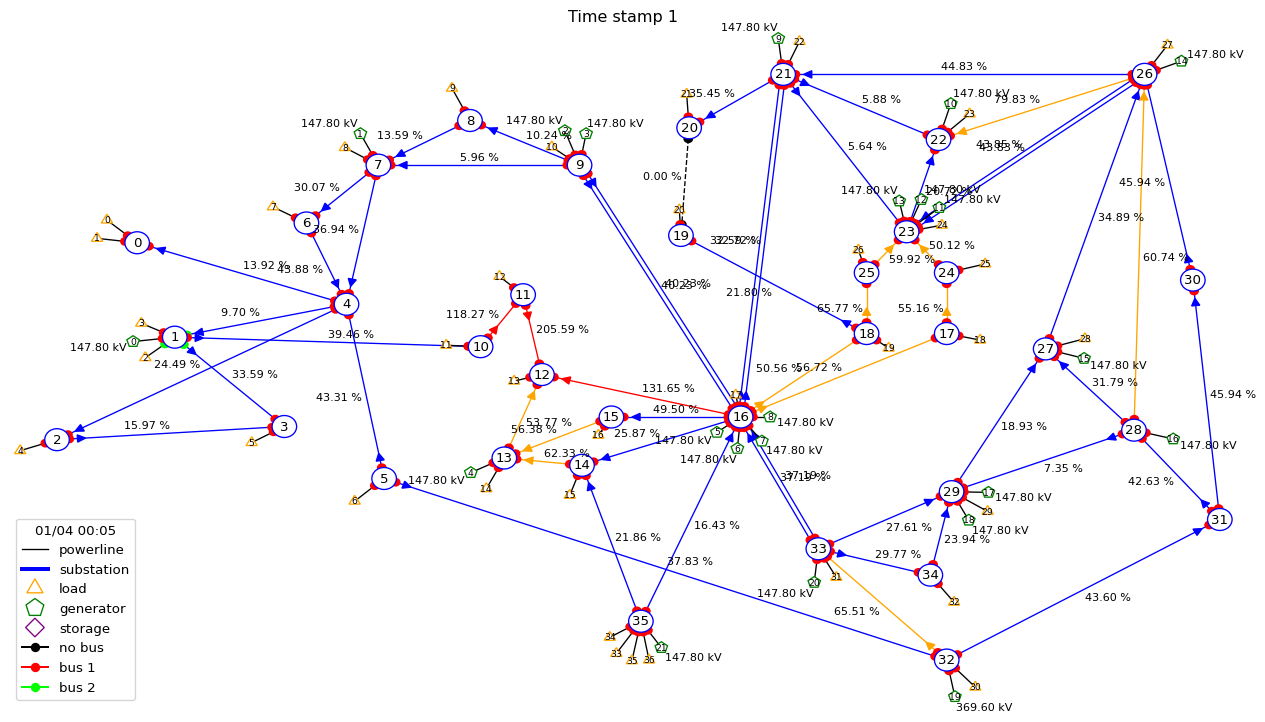

In [17]:
obs_plotter.visualize_next()

### Test OOD Generalization
There are always two power lines disconnected at random.

In [20]:
from lips.plot.power_grid import PlotData
obs_plotter = PlotData(dataset=benchmark1._test_ood_topo_dataset, env_name=benchmark1.env_name)

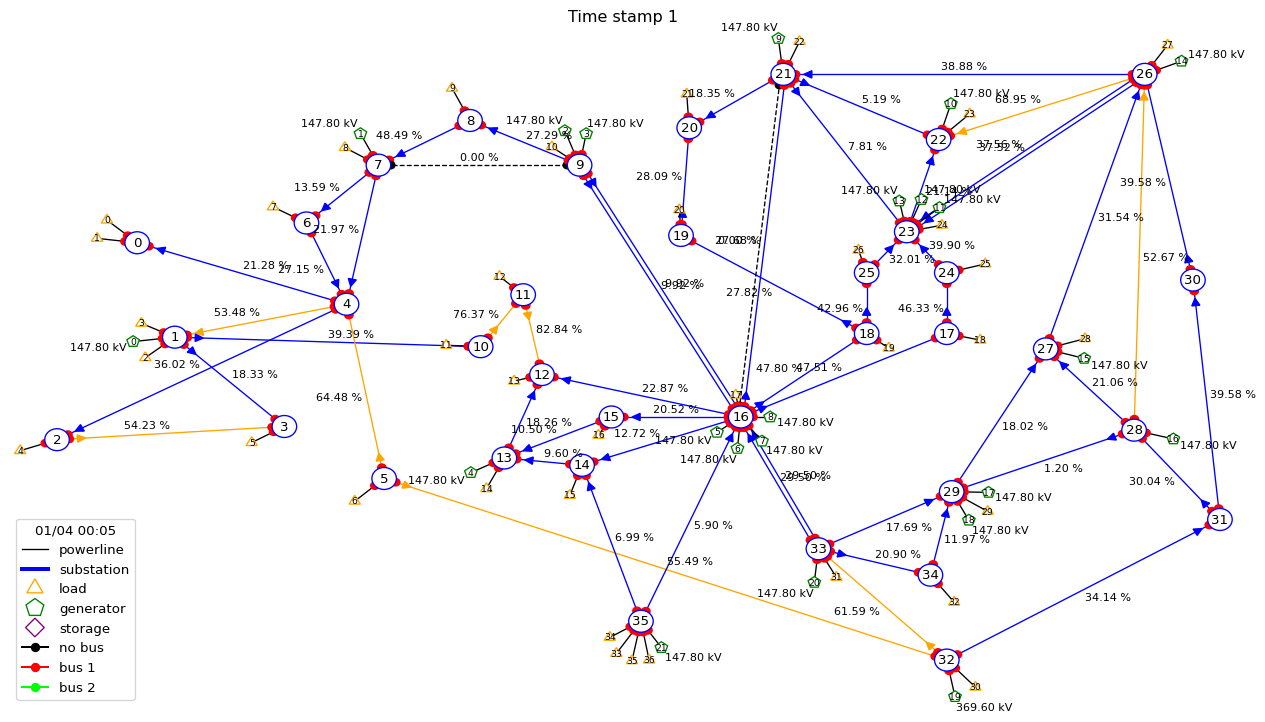

In [21]:
obs_plotter.visualize_next()

<h1 style="color:red">Draft</h1>

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force disconnection of 1 powerlines ([3])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Disconnect the following element(s):
	 	 - Disconnect line (origin) id 3 [on substation 1]
	 	 - Disconnect line (extremity) id 3 [on substation 3]


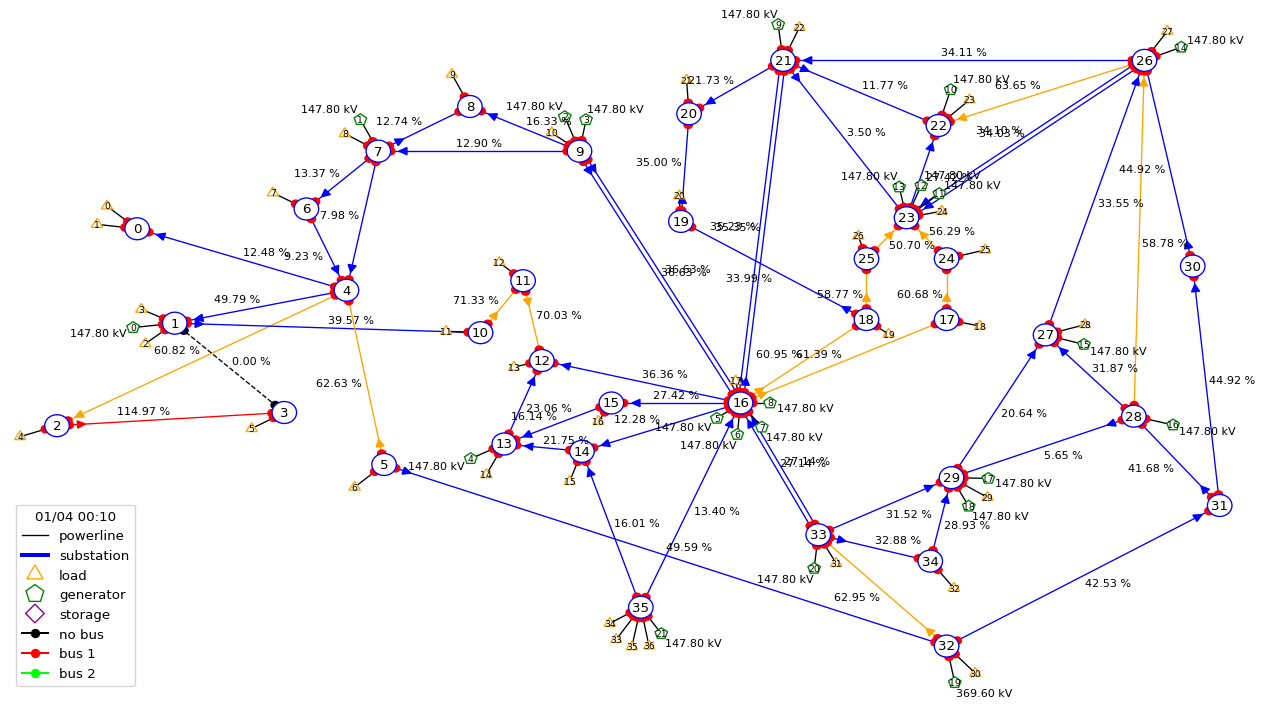

In [24]:
obs = benchmark1.env.reset()
action = benchmark1.training_actor.act(obs)
obs, reward, done, info = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)
print(action)

### Verfiy the chronics  (for debugging purpose, to be removed in future)

In [7]:
import re
import grid2op

In [8]:
env_nips = grid2op.make("l2rpn_neurips_2020_track1_small")

In [9]:
chronics_train_selected_regex="^((?!(.*[3-4][0-9].*)).)*$"
chronics_val_selected_regex=".*3[0-5].*"
chronics_test_selected_regex=".*3[5-9].*"
chronics_test_ood_selected_regex=".*4[0-9].*"
chronics_selected_regex = re.compile(chronics_train_selected_regex)
chronics = lambda path: re.match(chronics_selected_regex, path) is not None

In [ ]:
env_nips.chronics_handler.set_filter(chronics)
env_nips.chronics_handler.real_data.reset()

# Test (to be removed in future)

In [5]:
benchmark1._fills_actor_simulator()

/home/milad/environments/lips/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
/home/milad/environments/lips/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
/home/milad/environments/lips/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
/home/milad/environments/lips/lib/python3.8

In [ ]:
benchmark1.training_actor.reference_args

In [150]:
len(benchmark1.training_actor.topo_actions)

36

In [151]:
len(benchmark1.training_actor.ref_agent.topo_actions)

36

In [ ]:
benchmark1.training_actor.ref_agent.topo_actions

In [7]:
obs = benchmark1.env.reset()

In [ ]:
action = benchmark1.training_actor.act(obs)
print(action)

In [ ]:
from lips.benchmark.utils.powergrid_utils import XDepthAgent
from lips.config import ConfigManager
import numpy as np

In [ ]:
config = ConfigManager("Benchmark1", path=CONFIG_PATH)
env = benchmark1.env

In [ ]:
for i, action in enumerate(config.get_option("dataset_create_params")["reference_args"].get("topo_actions")):
    # print(i)
    action = env.action_space(action)
    impacted_sub = int(np.where(action.get_topological_impact()[1])[0])
    print(impacted_sub)

# Debug the errors

In [50]:
import numpy as np

In [51]:
env = benchmark1.env
obs = env.reset()

In [ ]:
nb_divergence = 0
for i in range(int(1e2)):
    print(i)
    done = True
    obs = env.reset()
    while done:
        action = benchmark1.training_actor.act(obs)
        sim_obs, sim_reward, sim_done, sim_info = obs.simulate(action)
        #env_obs, env_reward, env_done, env_info = env.step(action)
        
        if env_info["is_illegal"]:
            print(action)
            print(env_info)
            raise RuntimeError("Your `actor` should not take illegal action. Please modify the environment "
                                   "or your actor.")
        if done:
            nb_divergence += 1 

In [52]:
benchmark1.training_actor._info

{'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1], dtype=int32),
 'is_illegal': False,
 'is_ambiguous': False,
 'is_dispatching_illegal': False,
 'is_illegal_reco': False,
 'reason_alarm_illegal': None,
 'opponent_attack_line': None,
 'opponent_attack_sub': None,
 'opponent_attack_duration': 0,
 'exception': [],
 'rewards': {}}

In [15]:
attacked_line = int(np.where(env_info["opponent_attack_line"])[0])
print("Line {} is attacked".format(attacked_line))

Line 14 is attacked


In [14]:
env_obs.line_status

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

##### Another example

In [55]:
obs = env.reset()

In [56]:
for i in range(int(1e5)):
    obs, reward, done, info = env.step(env.action_space({}))
    if np.sum(obs.line_status != True) > 0:
        print("Line {} is attacked".format(int(np.where(info["opponent_attack_line"])[0])))
        print("Attack found")
        break

Line 56 is attacked
Attack found


In [59]:
dis_action = env.action_space({"set_line_status": [(10, -1)]})
obs, reward, done, info = env.step(dis_action)
done

In [62]:
info

{'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1], dtype=int32),
 'is_illegal': False,
 'is_ambiguous': False,
 'is_dispatching_illegal': False,
 'is_illegal_reco': False,
 'reason_alarm_illegal': None,
 'opponent_attack_line': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False]),
 'opponent_attack_sub': array([False, False, False, False, False, Fals

In [63]:
obs.line_status

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True])

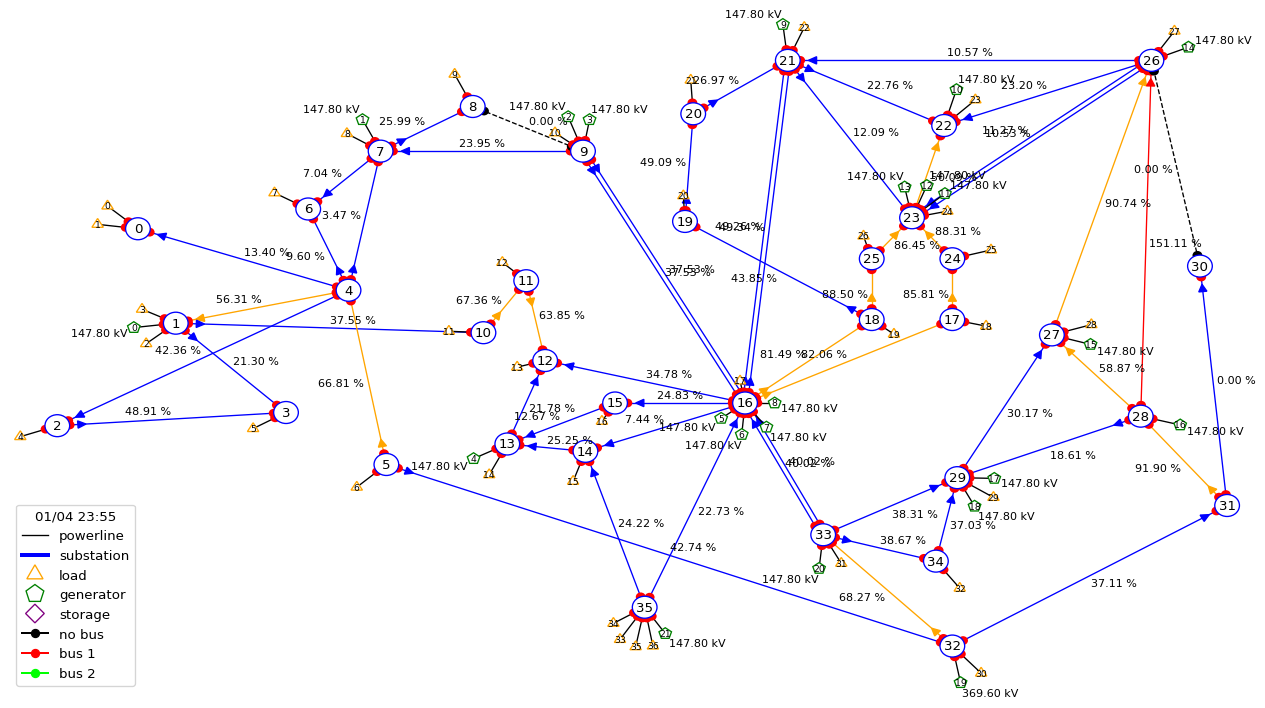

In [74]:
visualize_obs(benchmark1.env, obs)

##### An example with ref topo

In [25]:
ref_topo = env.action_space({"set_bus":
                               {"substations_id":
                                [(sub_id, np.ones(env.action_space.sub_info[sub_id], dtype=int))
                                 for sub_id in range(env.action_space.n_sub)]}})

some useful information concerning connectivity of subs and elements (lines, loads, gens)

In [19]:
sub_or = obs.line_or_to_subid[attacked_line]
sub_ex = obs.line_ex_to_subid[attacked_line]
sub_or_topo = obs.sub_topology(sub_or)
sub_ex_topo = obs.sub_topology(sub_ex)
line_ex_pos_topo = obs.line_ex_pos_topo_vect[attacked_line]
obs.get_obj_connect_to(substation_id=sub_or)

{'loads_id': array([13]),
 'generators_id': array([], dtype=int64),
 'lines_or_id': array([14, 20]),
 'lines_ex_id': array([13]),
 'storages_id': array([], dtype=int64),
 'nb_elements': 4}

In [40]:
action1 = env.action_space({"set_bus": {"lines_ex_id": [(attacked_line,-1)]}})
action2 = env.action_space({"set_bus": {"lines_or_id": [(attacked_line,-1)]}})